<a href="https://colab.research.google.com/github/RaicLee/learn_with_paper/blob/master/Mnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D,Concatenate
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras import backend as K
from keras.losses import binary_crossentropy,categorical_crossentropy
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

dddddda# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files 

In [53]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    #batch_y = np.expand_dims(batch_y,3)
    batch_y=to_categorical(batch_y)
    #(20,256,256)-> (20,256,256,2)
    yield (batch_x, batch_y)      
    

In [0]:
batch_size = 4

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

(256, 256, 3)
(256, 256)


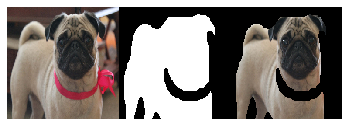

In [57]:
plt.axis('off')
img = x[0]
print(img.shape)
# (256,256,2)
msk = y[0,:,:,1]
print(msk.shape)
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [0]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [0]:
def dice_coef(y_true, y_pred, smooth=1):

    """
    y_true_f = K.flatten(y_true)

    y_pred_f = K.flatten(y_pred)
    """
    y_pred=K.argmax(y_pred,axis=-1)
    y_true=y_true[:,:,:,1]

    y_true_f=K.flatten(y_true)
    y_pred_f=K.flatten(y_pred)
    y_true_f=K.cast(y_true_f,'float32')
    y_pred_f=K.cast(y_pred_f,'float32')
    intersection = K.sum(y_true_f * y_pred_f)

    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

 

def dice_loss(y_true, y_pred):

    smooth = 1.

    y_pred=K.argmax(y_pred,axis=-1)
    y_true=y_true[:,:,:,1]

    y_true_f=K.flatten(y_true)
    y_pred_f=K.flatten(y_pred)
    y_true_f=K.cast(y_true_f,'float32')
    y_pred_f=K.cast(y_pred_f,'float32')

    
    """
    y_pred = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')

    y_true_f = K.flatten(y_true)

    y_pred_f = K.flatten(y_pred)
    """
    intersection = y_true_f * y_pred_f

    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    return 1. - score

 

# custom loss function
def cce_dice_loss(y_true, y_pred):

    return categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Model

In [0]:
def mnet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #Contracting layers
  nKernels = 4
  layers = []
  
  #level 2
  #(128,128,8)
  L_Reg_1=MaxPooling2D()(inputs)
  #level 3
  #(64,64,3)
  L_Reg_2=MaxPooling2D()(L_Reg_1)
  #level 4
  #(32,32,3)
  L_Reg_3=MaxPooling2D()(L_Reg_2)
  #level 5
  #(16,16,3)
  L_Reg_4=MaxPooling2D()(L_Reg_3)
  #level 6
  #(8,8,3)
  L_Reg_5=MaxPooling2D()(L_Reg_4)
  #(4,4,3)
  L_Reg_6=MaxPooling2D()(L_Reg_5)

  # level_1 (256, 256, 3)
  # level+ layer
  layer11 = Conv2D(nKernels, 3, activation='relu', kernel_initializer='he_normal', padding='same') (x)
  layer11 = BatchNormalization()(layer11)
  layer12 = Conv2D(nKernels*2, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer11)
  layer12 = BatchNormalization()(layer12)
  # skip-connection 을 통해 이어주려고 미리 layers에 저장해둠.
  layers.append(layer12)
  layer13 = MaxPooling2D() (layer12)
  
  # (128,128,16)+(128,128,3)
  layer13=Concatenate(axis=3)([L_Reg_1,layer13])

  # level_2 (128, 128, 8)
  layer21 = Conv2D(nKernels*2, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer13)
  layer21 = BatchNormalization()(layer21)
  layer22 = Conv2D(nKernels*4, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer21)
  layer22 = BatchNormalization()(layer22)
  layers.append(layer22)
  layer23 = MaxPooling2D() (layer22)

  #(64,64,32)+(64,64,3)
  layer23=Concatenate(axis=3)([L_Reg_2,layer23])
  # level_3 (64, 64, 16)
  layer31 = Conv2D(nKernels*4, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer23)
  layer31 = BatchNormalization()(layer31)
  layer32 = Conv2D(nKernels*8, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer31)
  layer32 = BatchNormalization()(layer32)
  layers.append(layer32)
  layer33 = MaxPooling2D() (layer32)


  #(32,32,64)+(32,32,3)
  layer33=Concatenate(axis=3)([L_Reg_3,layer33])

  # level_4 (32, 32, 32)
  layer41 = Conv2D(nKernels*8, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer33)
  layer41 = BatchNormalization()(layer41)
  layer42 = Conv2D(nKernels*16, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer41)
  layer42 = BatchNormalization()(layer42)
  layers.append(layer42)
  layer43 = MaxPooling2D() (layer42)


  #(16,16,128)+(16,16,3)
  layer43=Concatenate(axis=3)([L_Reg_4,layer43])
  # level_5 (16, 16, 64)
  layer51 = Conv2D(nKernels*16, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer43)
  layer51 = BatchNormalization()(layer51)
  layer52 = Conv2D(nKernels*32, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer51)
  layer52 = BatchNormalization()(layer52)
  layers.append(layer52)
  layer53 = MaxPooling2D() (layer52)


  #(8,8,256)+(8,8,3)
  layer53=Concatenate(axis=3)([L_Reg_5,layer53])

  # level_6 (8, 8, 128)
  layer61 = Conv2D(nKernels*32, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer53)
  layer61 = BatchNormalization()(layer61)
  layer62 = Conv2D(nKernels*64, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer61)
  layer62 = BatchNormalization()(layer62)
  layers.append(layer62)
  layer63 = MaxPooling2D() (layer62)
  
  #(4,4,512)+(4,4,3)
  layer63=Concatenate(axis=3)([L_Reg_6,layer63])


  # BottleNeck (4, 4, 256)
  bottleneck11 = Conv2D(nKernels*64, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer63)
  bottleneck11 = BatchNormalization()(bottleneck11)
  bottleneck12 = Conv2D(nKernels*64, 3, activation='relu', kernel_initializer='he_normal', padding='same') (bottleneck11)
  bottleneck12 = BatchNormalization()(bottleneck12)
  
  R_leg_6=bottleneck12

  bottleneck13 = Conv2DTranspose(nKernels*32, 2, strides=(2, 2), padding='same') (bottleneck12)
  level = len(layers) - 1
  layer71 = Concatenate(axis=3)([bottleneck13, layers[level]])
  
  # level 7 = level 6
  layer72 = Conv2D(nKernels*32, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer71)
  layer72 = BatchNormalization()(layer72)
  layer73 = Conv2D(nKernels*32, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer72)
  layer73 = BatchNormalization()(layer73)
  
  R_leg_5=layer73
  
  layer74 = Conv2DTranspose(nKernels*16, 2, strides=(2, 2), padding='same') (layer73)
  level = len(layers) - 2
  layer81 = Concatenate(axis=3)([layer74, layers[level]])
  R_leg_6=UpSampling2D()(R_leg_6)
  R_leg_5=Concatenate(axis=3)([R_leg_6,R_leg_5])


  # level 8 = level 5
  layer82 = Conv2D(nKernels*16, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer81)
  layer82 = BatchNormalization()(layer82)
  layer83 = Conv2D(nKernels*16, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer82)
  layer83 = BatchNormalization()(layer83)

  R_leg_4=layer83
  R_leg_5=UpSampling2D()(R_leg_5)
  R_leg_4=Concatenate(axis=3)([R_leg_5,R_leg_4])
  layer84 = Conv2DTranspose(nKernels*8, 2, strides=(2, 2), padding='same') (layer83)
  level = len(layers) - 3
  layer91 = Concatenate(axis=3)([layer84, layers[level]])

  # level 9 = level 4
  layer92 = Conv2D(nKernels*8, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer91)
  layer92 = BatchNormalization()(layer92)
  layer93 = Conv2D(nKernels*8, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer92)
  layer93 = BatchNormalization()(layer93)

  R_leg_3=layer93
  R_leg_4=UpSampling2D()(R_leg_4)
  R_leg_3=Concatenate(axis=3)([R_leg_4,R_leg_3])
  layer94 = Conv2DTranspose(nKernels*4, 2, strides=(2, 2), padding='same') (layer93)
  level = len(layers) - 4
  layer101 = Concatenate(axis=3)([layer94, layers[level]])

  # level 10 = level 3
  layer102 = Conv2D(nKernels*4, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer101)
  layer102 = BatchNormalization()(layer102)
  layer103 = Conv2D(nKernels*4, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer102)
  layer103 = BatchNormalization()(layer103)

  R_leg_2=layer103
  R_leg_3=UpSampling2D()(R_leg_3)
  R_leg_2=Concatenate(axis=3)([R_leg_3,R_leg_2])
  layer104 = Conv2DTranspose(nKernels*2, 2, strides=(2, 2), padding='same') (layer103)
  level = len(layers) - 5
  layer111 = Concatenate(axis=3)([layer104, layers[level]])
  
  # level 11 = level 2
  layer112 = Conv2D(nKernels*2, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer111)
  layer112 = BatchNormalization()(layer112)
  layer113 = Conv2D(nKernels*2, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer112)
  layer113 = BatchNormalization()(layer113)

  R_leg_1=layer113
  R_leg_2=UpSampling2D()(R_leg_2)
  R_leg_1=Concatenate(axis=3)([R_leg_2,R_leg_1])

  layer114 = Conv2DTranspose(nKernels, 2, strides=(2, 2), padding='same') (layer113)
  level = len(layers) - 6
  layer121 = Concatenate(axis=3)([layer114, layers[level]])
      
  #level 1 = classification 
  R_leg_0=UpSampling2D()(R_leg_1)
  layer121=Concatenate(axis=3)([layer121,R_leg_0])
  classification1 = Conv2D(nKernels, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer121)
  classification1 = BatchNormalization()(classification1)
  classification2 = Conv2D(nKernels, 3, activation='relu', kernel_initializer='he_normal', padding='same') (classification1)
  classification2 = BatchNormalization()(classification2)
  outputs = Conv2D(2, 1, activation='softmax') (classification2)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  # model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  model.compile(optimizer = 'rmsprop', loss = cce_dice_loss, metrics = [mean_iou])
  
  return model

In [61]:
model = mnet()

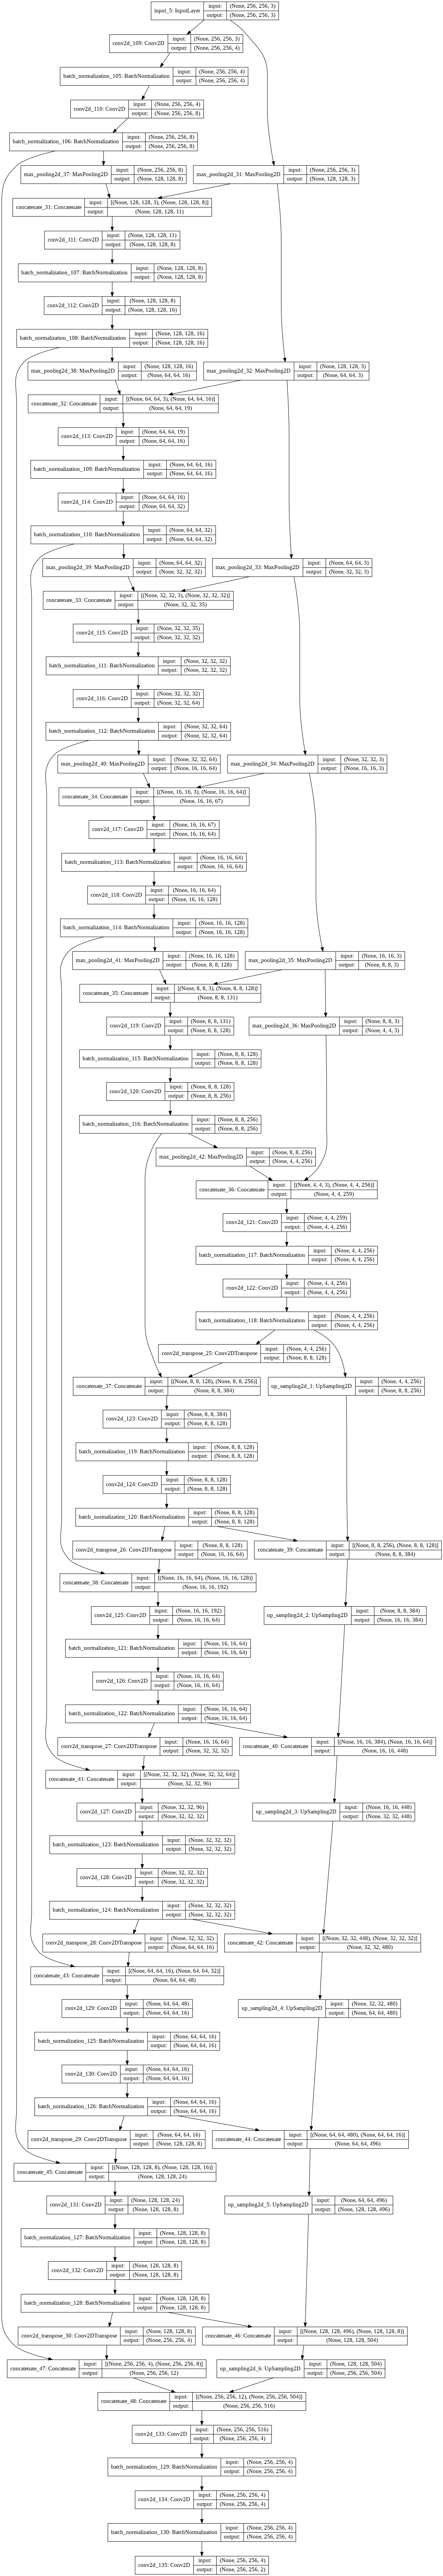

In [62]:
plot_model(model,to_file='model_plot.png',show_shapes=True,show_layer_names=True)

# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        # (256,256,3) -> (1,256,256,3) -> (1,256,256,2)
        pred = model.predict(np.expand_dims(raw, 0))
        #input (256,256,3) -->(1,256,256,2)
        #shape of pred (1,256,256,2)
        #mask post-processing 
        msk=np.argmax(pred,axis=-1)
        #(1,256,256,2)->(1,256,256,1)
        msk=msk.squeeze()
        #->(256,256,1)
        msk=np.stack((msk,)*3,axis=-1)

        """
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        """
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

i= 1 loss= 0.6126829652789652 val_loss= 0.4888201161571171 mean_iou= 0.8067019323677759 val_mean_iou= 0.8366558214892512


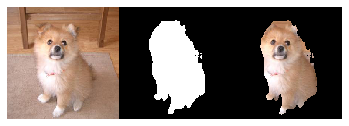

i= 2 loss= 0.427366942498419 val_loss= 0.42018491386071494 mean_iou= 0.8635096243643693 val_mean_iou= 0.8648404951976694


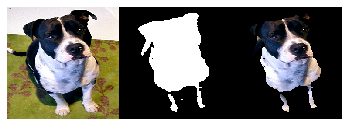

i= 3 loss= 0.3668603745281187 val_loss= 0.37839461336641206 mean_iou= 0.881902751080331 val_mean_iou= 0.8826663714388142


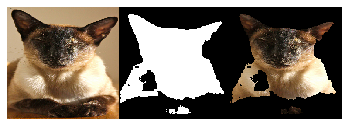

i= 4 loss= 0.32831687090913114 val_loss= 0.3458351177041945 mean_iou= 0.8944041308514413 val_mean_iou= 0.8809143849041151


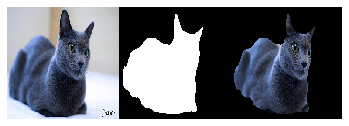

i= 5 loss= 0.2982940494377389 val_loss= 0.29120833912621374 mean_iou= 0.9025797337548346 val_mean_iou= 0.8989304783551589


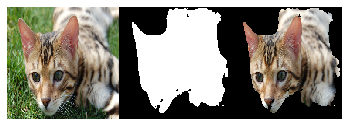

i= 6 loss= 0.27303236549311555 val_loss= 0.3156439125861811 mean_iou= 0.9109430700965077 val_mean_iou= 0.8922199004370234


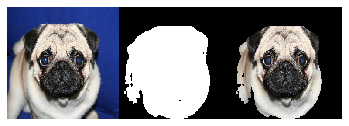

i= 7 loss= 0.25795941793086524 val_loss= 0.2994950640460719 mean_iou= 0.9147999219744973 val_mean_iou= 0.8994237495505292


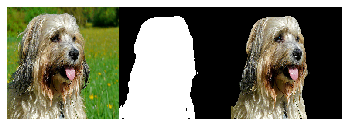

i= 8 loss= 0.24343838426801895 val_loss= 0.30912386739383574 mean_iou= 0.9203579189091327 val_mean_iou= 0.8876064037499221


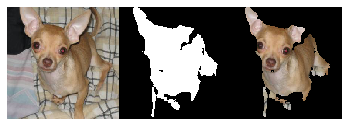

i= 9 loss= 0.22766938603501713 val_loss= 0.2705357549307139 mean_iou= 0.924876152008687 val_mean_iou= 0.9075114072664924


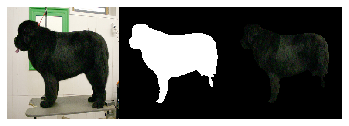

i= 10 loss= 0.22026211989571226 val_loss= 0.2868665484306605 mean_iou= 0.9269799818000902 val_mean_iou= 0.9049878956183143


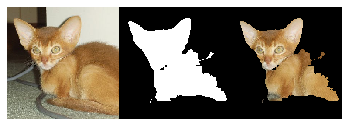

i= 11 loss= 0.21231402050905418 val_loss= 0.2949515330078809 mean_iou= 0.9301314606965437 val_mean_iou= 0.9017907115428344


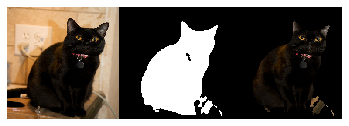

i= 12 loss= 0.19900987819898502 val_loss= 0.27830802487290424 mean_iou= 0.9330425914875802 val_mean_iou= 0.9050669741371403


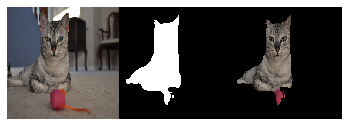

i= 13 loss= 0.19303617537276357 val_loss= 0.265866436874089 mean_iou= 0.9354717303884674 val_mean_iou= 0.9112969928461573


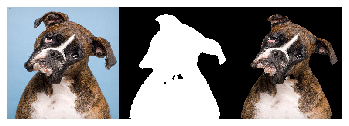

i= 14 loss= 0.1847923982941527 val_loss= 0.3017503338987413 mean_iou= 0.9384780689182445 val_mean_iou= 0.8980008616395618


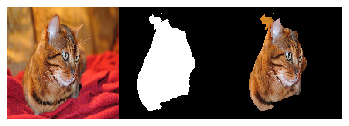

i= 15 loss= 0.17831755200682203 val_loss= 0.336625303182265 mean_iou= 0.9396151984858717 val_mean_iou= 0.8890477269887924


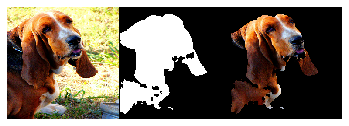

i= 16 loss= 0.17229966064463992 val_loss= 0.2666558110681565 mean_iou= 0.9413451996284332 val_mean_iou= 0.9087944063155547


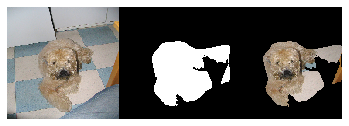

i= 17 loss= 0.16862497311032396 val_loss= 0.27549184591549897 mean_iou= 0.9430745194780181 val_mean_iou= 0.9115402568941531


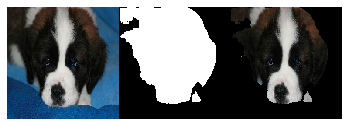

i= 18 loss= 0.16003209467966673 val_loss= 0.26230465977088263 mean_iou= 0.9453241580911511 val_mean_iou= 0.9083258742871492


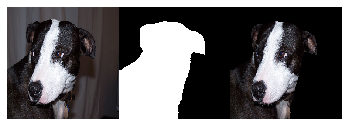

KeyboardInterrupt: ignored

In [64]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [65]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2020-03-12 15:44:14--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.224.164.6, 13.224.164.117, 13.224.164.41, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.224.164.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.02s   

2020-03-12 15:44:14 (2.96 MB/s) - ‘test.jpg’ saved [63219/63219]



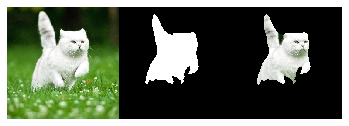

In [66]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))
msk=np.argmax(pred,axis=-1)
msk=msk.squeeze()
msk=np.stack((msk,)*3,axis=-1)
#mask post-processing 
"""
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 
"""
#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

